# A notebook for descriptive statistics about the different methods.

Purpose of this notebook is to find the distribution for respective post-processing method, so that we can simulate different ratios, and have a benchmark curve, instead of a flat curve.


In [4]:
# set fcs
fcs =  [round(i*0.2,2) for i in range(9)] + [0.68]


In [5]:


import pandas as pd
import numpy as np

from scipy import stats

import os 

os.chdir("/home/ptruong/git/dia_sum/scripts/PXD002952")

from q_value import qvalues
from triqler_output_to_df import  parse_triqler
os.chdir("/hdd_14T/data/PXD002952/osw_res_20210303/hye124/ttof6600/32fix/full_ts_v")



# filename has different formatting, we need to change number or implement regex.
experiment_id_mapper = lambda x: x.split("_")[5]
sample_id_mapper = lambda x: x.split("_")[8] #hye124 
specie_mapper = lambda x: x.split("_")[-1]
def decoy_mapper(x):
    if x.split("_")[0] == "DECOY":
        return True
    else:
        return False
    
def read_in_and_filter(filename, m_score_treshold = 0.01):  
    print(filename)
    df = pd.read_csv(filename, sep = "\t")
    df = df[df.decoy != 1]
    df = df[df.m_score < m_score_treshold] # filter away crap, so all values should be good... we take average of top3 here
    print(str(len(df)) + " significantly identified peptides at " + str(m_score_treshold) + " FDR-treshold.")
    print("")
    df["experiment_id"] = df["filename"].map(experiment_id_mapper)
    df["sample_id"] = df["filename"].map(sample_id_mapper)
    sample_id = df.sample_id[0]
    experiment_id = df.experiment_id[0]     
    def top3(df):
        df = (df.groupby('ProteinName')['Intensity'].apply(lambda x: x.nlargest(3).mean() if len(x.nlargest(3)) >= 2 else np.nan)
                  .reset_index())
        #print(df.isna().sum())
        return df
    df_reduced = df[["ProteinName", "Intensity"]]
    df_protein = top3(df_reduced)
    df = df_protein
    df["specie"] = df.ProteinName.map(specie_mapper)
    midx = pd.MultiIndex(levels = [[sample_id],[experiment_id]], codes = [[0],[0]], names = ["sample_id", "experiment_id"])
    df = df.set_index(["specie", "ProteinName"])
    df = pd.DataFrame(df.values, columns = midx, index = df.index)
    
    return df



# highest scoring vs top highest intenstiy peptide?
# We take top3 intensity because we filter away so much with m_score < 0.01, all values should be good.

dfs = []
for file in os.listdir():
    if file[-4:] == ".tsv":
        dfs.append(read_in_and_filter(file, m_score_treshold=0.01))
        #print(len(df_part))
        #df = pd.concat([df, df_part],axis = 1)        
df = pd.concat(dfs, axis = 1)

df["decoy"] = df.index.get_level_values("ProteinName").map(decoy_mapper) 
df.decoy.sum()

A = df[df.iloc[:, df.columns.get_level_values("sample_id") == "1"].isna().sum(axis=1)<2]
A = A.iloc[:,A.columns.get_level_values("sample_id") == "1"]
#A = np.log2(A)
B = df[df.iloc[:, df.columns.get_level_values("sample_id") == "2"].isna().sum(axis=1)<2]
B = B.iloc[:,B.columns.get_level_values("sample_id") == "2"]
#B = np.log2(B)

# Find overlapping proteins
overlapping_proteins = list(set(A.index) & set(B.index))
A = A[A.index.isin(overlapping_proteins)]
B = B[B.index.isin(overlapping_proteins)]





import scipy.stats as stats

p_vals = stats.ttest_ind(A, B, axis = 1)[1]
p_vals = pd.DataFrame(p_vals, columns = ["p"])
p_vals["q"] = qvalues(p_vals)
p_vals = pd.DataFrame(p_vals.values, index = A.index, columns = ["p", "q"])
p_vals.sort_values("q",inplace =True)
p_vals = p_vals.astype(float)

A = np.log2(A.sum(axis=1))
B = np.log2(B.sum(axis=1))

A.name = "1"
B.name = "2"

df_final = pd.concat([A, B, p_vals], axis = 1)
df_final["log2(A,B)"] = df_final["1"] - df_final["2"]

def pq_data(df_final, fc_treshold):
    # two-side treshold because triqler uses two side treshold.
    df_final_fc_gt = (df_final[df_final["log2(A,B)"] > fc_treshold])
    df_final_fc_lt = (df_final[df_final["log2(A,B)"] < -fc_treshold])
    df_final_fc = pd.concat([df_final_fc_gt, df_final_fc_lt])
    n_array = []
    for q in np.arange(0,0.101, 0.001):
        n = (df_final_fc["q"] <= q).sum()
        n_array.append(n)
    res = pd.DataFrame(n_array, index = np.arange(0,0.101, 0.001), columns = ["DE"])
    return res

# test
#pq_data(df_final[df_final.index.get_level_values("specie") == "HUMAN"], fc_treshold = 0.2)
#pq_data(df_final[df_final.index.get_level_values("specie") == "YEAS8"], fc_treshold = 0.2)
#pq_data(df_final[df_final.index.get_level_values("specie") == "ECOLI"], fc_treshold = 0.2)


import matplotlib.pyplot as plt

specie = "HUMAN"

def plot_pq(df_final, specie):
    fig, axs = plt.subplots(2, 5)
    row = 0
    col = 0
    for i in range(10):
        fc =i*0.2
        df = pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = fc)
        if i == 0:
            y_lim = df.max()[0]
        axs[row, col].plot(df.index, df.DE)
        axs[row, col].set_ylim([0, y_lim])
        axs[row, col].set_title(f"fc = {fc}")
        axs[row, col].set_xlabel("q-value")
        axs[row, col].set_ylabel("n - Differentially expressed.")
        col += 1
        if col == 5:
            row +=1
            col = 0
    plt.suptitle("OSW top3 " + specie)
    plt.show()


import time
from triqler_output_to_df import  parse_triqler
os.chdir("/hdd_14T/data/PXD002952/osw_res_20210303/hye124/ttof6600/32fix/triqler_results")

def get_pq_data_triqler(q_val):
    fc_tresh = []
    n_hs = []
    n_ye = []
    n_ec = []
    
    for file in sorted(os.listdir()):       
        fc = float(file.split("_")[1])
        df_triq = parse_triqler(file)
        df_triq = df_triq[df_triq.q_value < q_val]
        df_triq["specie"] = df_triq.protein.map(specie_mapper)
        n_hs.append((df_triq["specie"] == "HUMAN").sum())
        n_ye.append((df_triq["specie"] == "YEAS8").sum())
        n_ec.append((df_triq["specie"] == "ECOLI").sum())
        fc_tresh.append(fc)
    
    df =pd.DataFrame(np.array([n_hs, n_ye, n_ec]).T, index = fc_tresh, columns = ["HUMAN", "YEAS8", "ECOLI"])
    return df

def map_decoy(x):
    if x.split("_")[0] == "DECOY":
        return True
    else:
        return False

#start = time.time()
def get_DE_for_fcs(fcs =  [round(i*0.2,2) for i in range(9)] + [0.68]):
    qs = []
    dfs = []
    for q in np.arange(0,0.101, 0.001):
        qs.append(q)
        dfs.append(get_pq_data_triqler(q))
        #print(time.time()-start)
    end = time.time()
    #print(end-start)
    
    fcs = fcs
    fcs.sort()
    res = []
    for fc in fcs:
        vals = []
        for df in dfs:
            val = list(df[df.index == fc].values[0])
            vals.append(val)    
        df_res = pd.DataFrame(vals, index = np.arange(0,0.101, 0.001), columns = ["HUMAN", "YEAS8", "ECOLI"])
        res.append(df_res)
    return res

res = get_DE_for_fcs( fcs = fcs)



def msstats_pq_data(ms, fc):
    # ms = pd.read_csv("msstats.csv")
    ms_gt = ms[ms.log2FC > fc]
    ms_lt = ms[ms.log2FC < -fc]
    ms_fc = pd.concat([ms_gt, ms_lt])
    n_array = []
    for q in np.arange(0,0.101, 0.001):
        n = (ms_fc["adj.pvalue"] <= q).sum()
        n_array.append(n)
    res = pd.DataFrame(n_array, index = np.arange(0,0.101, 0.001), columns = ["DE"])
    return res

# MSSTATS
os.chdir("/hdd_14T/data/PXD002952/osw_res_20210303/hye124/ttof6600/32fix")

ms = pd.read_csv("msstats.csv")
ms["specie"] = ms.Protein.map(specie_mapper)

ms[ms.specie == "YEAS8"]

#Rewrite this to function subplot
def plot_pq_specie(specie):
    fig, axs = plt.subplots(2, 5)
    row = 0
    col = 0
    #specie = "ECOLI"
    fcs = [round(i*0.2,2) for i in range(9)] + [0.68]
    fcs.sort()
    for i in range(10):
        fc = fcs[i]
        res[i][specie].plot(ax = axs[row,col]) #triqler data plot
        df = pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = fc)
        df_ms = msstats_pq_data(ms[ms.specie == specie], fc = fc)
        axs[row, col].plot(df.index, df.DE) # plot osw top3
        axs[row, col].plot(df_ms.index, df_ms.DE) # plot MSSTATS
        axs[row, col].legend(labels=["Triqler", "OSW Top3", "msStats"])
        axs[row, col].set_title(f"fc = {fc}")
        axs[row, col].set_xlabel("q-value")
        axs[row, col].set_ylabel("n - Differentially expressed.")
        col+=1
        if col == 5:
            row+=1
            col=0
    plt.suptitle(f"Differentially expressed proteins {specie} ( True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )")# + specie)
    plt.show()


os.chdir("/home/ptruong/git/MSqRobSum/inst/extdata")
os.chdir("/hdd_14T/data/PXD002952/osw_res_20210303/hye124/ttof6600/32fix/mSqRobSum_input")

msqrob = pd.read_csv("msqrobsum_result.csv", sep = "\t")
msqrob["specie"] = msqrob.proteins.map(specie_mapper)

msqrob

def msqrob_pq_data(msqrob, fc):
    msqrob_gt = msqrob[msqrob.logFC > fc]
    msqrob_lt = msqrob[msqrob.logFC < -fc]
    msqrob_fc = pd.concat([msqrob_gt, msqrob_lt])
    n_array = []
    for q in np.arange(0,0.101, 0.001):
        n = (msqrob_fc["qvalue"] <= q).sum()
        n_array.append(n)
    res = pd.DataFrame(n_array, index = np.arange(0,0.101, 0.001), columns = ["DE"])
    return res

msqrob_pq_data(msqrob, fc = 0.2)



HYE124_TTOF6600_32fix_lgillet_I150211_005-Pedro_-_Sample_2_-_SW32_-_Repl2.mzML.tsv
33070 significantly identified peptides at 0.01 FDR-treshold.

HYE124_TTOF6600_32fix_lgillet_I150211_006-Pedro_-_Sample_1_-_SW32_-_Repl3.mzML.tsv
31895 significantly identified peptides at 0.01 FDR-treshold.

HYE124_TTOF6600_32fix_lgillet_I150211_003-Pedro_-_Sample_2_-_SW32_-_Repl1.mzML.tsv
32521 significantly identified peptides at 0.01 FDR-treshold.

HYE124_TTOF6600_32fix_lgillet_I150211_004-Pedro_-_Sample_1_-_SW32_-_Repl2.mzML.tsv
31588 significantly identified peptides at 0.01 FDR-treshold.

HYE124_TTOF6600_32fix_lgillet_I150211_007-Pedro_-_Sample_2_-_SW32_-_Repl3.mzML.tsv
33516 significantly identified peptides at 0.01 FDR-treshold.

HYE124_TTOF6600_32fix_lgillet_I150211_002-Pedro_-_Sample_1_-_SW32_-_Repl1.mzML.tsv
31707 significantly identified peptides at 0.01 FDR-treshold.



In [35]:

#Rewrite this to function subplot
def plot_pq_specie(specie, fcs =  [round(i*0.2,2) for i in range(9)] + [0.68]):
    fig, axs = plt.subplots(2, 5, figsize=(20,15))
    row = 0
    col = 0
    #specie = "ECOLI"
    fcs = fcs
    if len(fcs) > 10:
        print("len fcs should be <= 10")
    fcs.sort()
    for i in range(10):
        fc = fcs[i]
        if specie == "all":
            res[i].sum(axis=1).plot(ax = axs[row,col]) #triqler data plot
            df = pq_data(df_final, fc_treshold = fc)
            df_ms = msstats_pq_data(ms, fc = fc)
            df_msqrob = msqrob_pq_data(msqrob, fc = fc)
        else:
            res[i][specie].plot(ax = axs[row,col]) #triqler data plot
            df = pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = fc)
            df_ms = msstats_pq_data(ms[ms.specie == specie], fc = fc)
            df_msqrob = msqrob_pq_data(msqrob[msqrob.specie == specie], fc = fc)
        axs[row, col].plot(df.index, df.DE) # plot osw top3
        axs[row, col].plot(df_ms.index, df_ms.DE) # plot MSSTATS
        axs[row, col].plot(df_msqrob.index, df_msqrob.DE) # plot msqrob
        axs[row, col].legend(labels=["Triqler", "OSW Top3", "msStats", "mSqRob"])
        axs[row, col].set_title(f"fc = {fc}")
        axs[row, col].set_xlabel("q-value")
        axs[row, col].set_ylabel("n - Differentially expressed.")
        col+=1
        if col == 5:
            row+=1
            col=0
    plt.suptitle(f"Differentially expressed proteins {specie} ( True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )")# + specie)
    plt.show()



#Rewrite this to function subplot
def plot_pq_specie_FP(specie, fcs):
    fig, axs = plt.subplots(2, 5, figsize=(20,15))
    row = 0
    col = 0
    #specie = "ECOLI"
    fcs = fcs
    fcs.sort()
    for i in range(10):
        fc = fcs[i]
        
        if specie == "all":
            df = pq_data(df_final, fc_treshold = fc)
            df_triq = res[i].sum(axis=1)
            df_ms = msstats_pq_data(ms, fc = fc)
            df_msqrob = msqrob_pq_data(msqrob, fc = fc)
        else:
            df = pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = fc)
            df_triq = res[i][specie]
            df_ms = msstats_pq_data(ms[ms.specie == specie], fc = fc)
            df_msqrob = msqrob_pq_data(msqrob[msqrob.specie == specie], fc = fc)

        # False positives
        df_FP = pq_data(df_final[df_final.index.get_level_values("specie") == "HUMAN"], fc_treshold = fc)
        df_triq_FP = res[i]["HUMAN"]
        df_ms_FP = msstats_pq_data(ms[ms.specie == "HUMAN"], fc = fc)
        df_msqrob_FP = msqrob_pq_data(msqrob[msqrob.specie == "HUMAN"], fc = fc)
        """
        if fc >= 1.0:
            df_FP_yeast = pq_data(df_final[df_final.index.get_level_values("specie") == "YEAS8"], fc_treshold = fc)
            df_triq_FP_yeast = res[i]["YEAS8"]
            df_ms_FP_yeast = msstats_pq_data(ms[ms.specie == "YEAS8"], fc = fc)
            df_msqrob_FP_yeast = msqrob_pq_data(msqrob[msqrob.specie == "YEAS8"], fc = fc)
            
            df_FP += df_FP_yeast
            df_triq_FP += df_triq_FP_yeast
            df_ms_FP += df_ms_FP_yeast
            df_msqrob_FP += df_msqrob_FP_yeast
        """ 
        df_triq.plot(ax = axs[row,col], style = "b") #triqler data plot
        axs[row, col].plot(df.index, df.DE, "k") # plot osw top3
        axs[row, col].plot(df_ms.index, df_ms.DE, "g") # plot MSSTATS
        axs[row, col].plot(df_msqrob.index, df_msqrob.DE, "r") # plot msqrob
        
        # Plot False positives
        #res[i]["HUMAN"].plot(ax = axs[row,col], style="b--") #triqler data plot
        df_triq_FP.plot(ax = axs[row, col], style="b--")
        axs[row, col].plot(df.index, df_FP.DE, "k--") # plot osw top3
        axs[row, col].plot(df_ms.index, df_ms_FP.DE, "g--") # plot MSSTATS
        axs[row, col].plot(df_msqrob.index, df_msqrob_FP.DE, "r--") # plot msqrob
        

        axs[row, col].legend(labels=["Triqler", "OSW Top3", "msStats", "mSqRob",
                                      "Triqler FP", "OSW Top3 FP", "msStats FP", "mSqRob FP" ])
        axs[row, col].set_title(f"fc = {fc}")
        axs[row, col].set_xlabel("q-value")
        axs[row, col].set_ylabel("n - Differentially expressed.")
        col+=1
        if col == 5:
            row+=1
            col=0
    plt.suptitle(f"Differentially expressed proteins {specie} ( True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )")# + specie)
    plt.show()


#FP ratio
def plot_ratio_FP_DE(specie, fcs):
    fig, axs = plt.subplots(2, 5,figsize=(20,15))
    row = 0
    col = 0
    #specie = "ECOLI"
    fcs = fcs
    fcs.sort()
    for i in range(10):
        fc = fcs[i]
        if specie == "all":
            df = (pq_data(df_final[df_final.index.get_level_values("specie") == "HUMAN"], fc_treshold = fc) / 
                  pq_data(df_final, fc_treshold = fc))
            df_triq = (res[i]["HUMAN"] / 
                       res[i].sum(axis=1))
            df_ms = (msstats_pq_data(ms[ms.specie == "HUMAN"], fc = fc) / 
                     msstats_pq_data(ms, fc = fc))
            df_msqrob = (msqrob_pq_data(msqrob[msqrob.specie == "HUMAN"], fc = fc) / 
                         msqrob_pq_data(msqrob, fc = fc))        
        else:
            df = (pq_data(df_final[df_final.index.get_level_values("specie") == "HUMAN"], fc_treshold = fc) / 
                  pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = fc))
            df_triq = (res[i]["HUMAN"] / 
                       res[i][specie])
            df_ms = (msstats_pq_data(ms[ms.specie == "HUMAN"], fc = fc) / 
                     msstats_pq_data(ms[ms.specie == specie], fc = fc))
            df_msqrob = (msqrob_pq_data(msqrob[msqrob.specie == "HUMAN"], fc = fc) / 
                         msqrob_pq_data(msqrob[msqrob.specie == specie], fc = fc))        

        df_triq.plot(ax = axs[row, col], style = "b") # triqler data plot
        axs[row, col].plot(df.index, df.DE, "m") # plot osw top3
        axs[row, col].plot(df_ms.index, df_ms.DE, "g") # plot MSSTATS
        axs[row, col].plot(df_msqrob.index, df_msqrob.DE, "r") # plot msqrob

        axs[row, col].legend(labels=["Triqler", "OSW Top3", "msStats", "mSqRob", ])
        axs[row, col].set_title(f"fc = {fc}")
        axs[row, col].set_xlabel("q-value")
        axs[row, col].set_ylabel("ratio FP/DE - Differentially expressed.")
        
        def abline(slope, intercept, row, col):
            """Plot a line from slope and intercept"""
            axes = plt.gca()
            x_vals = np.array(axs[row,col].get_xlim())
            y_vals = intercept + slope * x_vals
            axs[row,col].plot(x_vals, y_vals, 'k--', alpha = 0.7)
        abline(1,0,row,col)
        col+=1
        if col == 5:
            row+=1
            col=0
    plt.suptitle(f"Ratio FP / Differentially expressed proteins ( True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )")# + specie)
    plt.show()




#Rewrite this to function subplot
def plot_de_specie_xy(specie_x, specie_y, fcs):
    fig, axs = plt.subplots(2, 5, figsize=(20,15))
    row = 0
    col = 0
    #specie = "ECOLI"
    fcs = fcs
    fcs.sort()
    for i in range(10):
        fc = fcs[i]
        
        df_triq_x = res[i][specie_x]
        df_x = pq_data(df_final[df_final.index.get_level_values("specie") == specie_x], fc_treshold = fc)
        df_ms_x = msstats_pq_data(ms[ms.specie == specie_x], fc = fc)
        df_msqrob_x = msqrob_pq_data(msqrob[msqrob.specie == specie_x], fc = fc)
        
        df_triq_y = res[i][specie_y]
        df_y = pq_data(df_final[df_final.index.get_level_values("specie") == specie_y], fc_treshold = fc)
        df_ms_y = msstats_pq_data(ms[ms.specie == specie_y], fc = fc)
        df_msqrob_y = msqrob_pq_data(msqrob[msqrob.specie == specie_y], fc = fc)
        
        #df_triq_x.plot(ax = axs[row,col]) #triqler data plot        
        #axs[row, col].plot(df.index, df.DE) # plot osw top3
        #axs[row, col].plot(df_ms.index, df_ms.DE) # plot MSSTATS
        #axs[row, col].plot(df_msqrob.index, df_msqrob.DE) # plot msqrob
        
        axs[row, col].plot(df_triq_x.values, df_triq_y.values)
        axs[row, col].plot(df_x.values, df_y.values)
        axs[row, col].plot(df_ms_x.values, df_ms_y.values)
        axs[row, col].plot(df_msqrob_x.values, df_msqrob_y.values)
        
        axs[row, col].legend(labels=["Triqler", "OSW Top3", "msStats", "mSqRob"])
        axs[row, col].set_title(f"fc = {fc}")
        axs[row, col].set_xlabel(f"n - Differentially expressed {specie_x}")
        axs[row, col].set_ylabel(f"n - Differentially expressed {specie_y}")
        col+=1
        if col == 5:
            row+=1
            col=0
    plt.suptitle(f"Differentially expressed proteins specie ratio ( True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )")# + specie)
    plt.show()


# PQ-plots

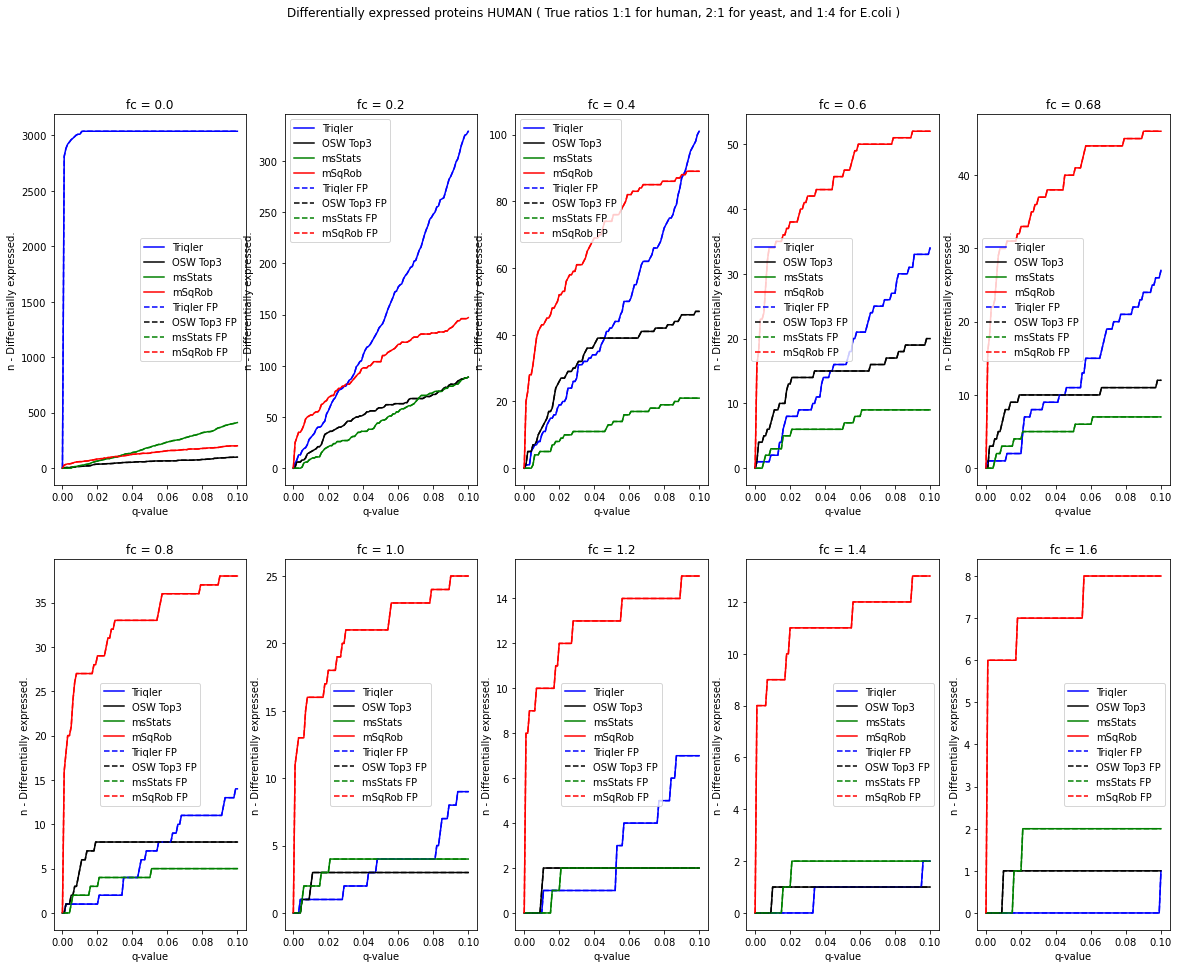

In [24]:
plot_pq_specie_FP(specie = "HUMAN", fcs = fcs)


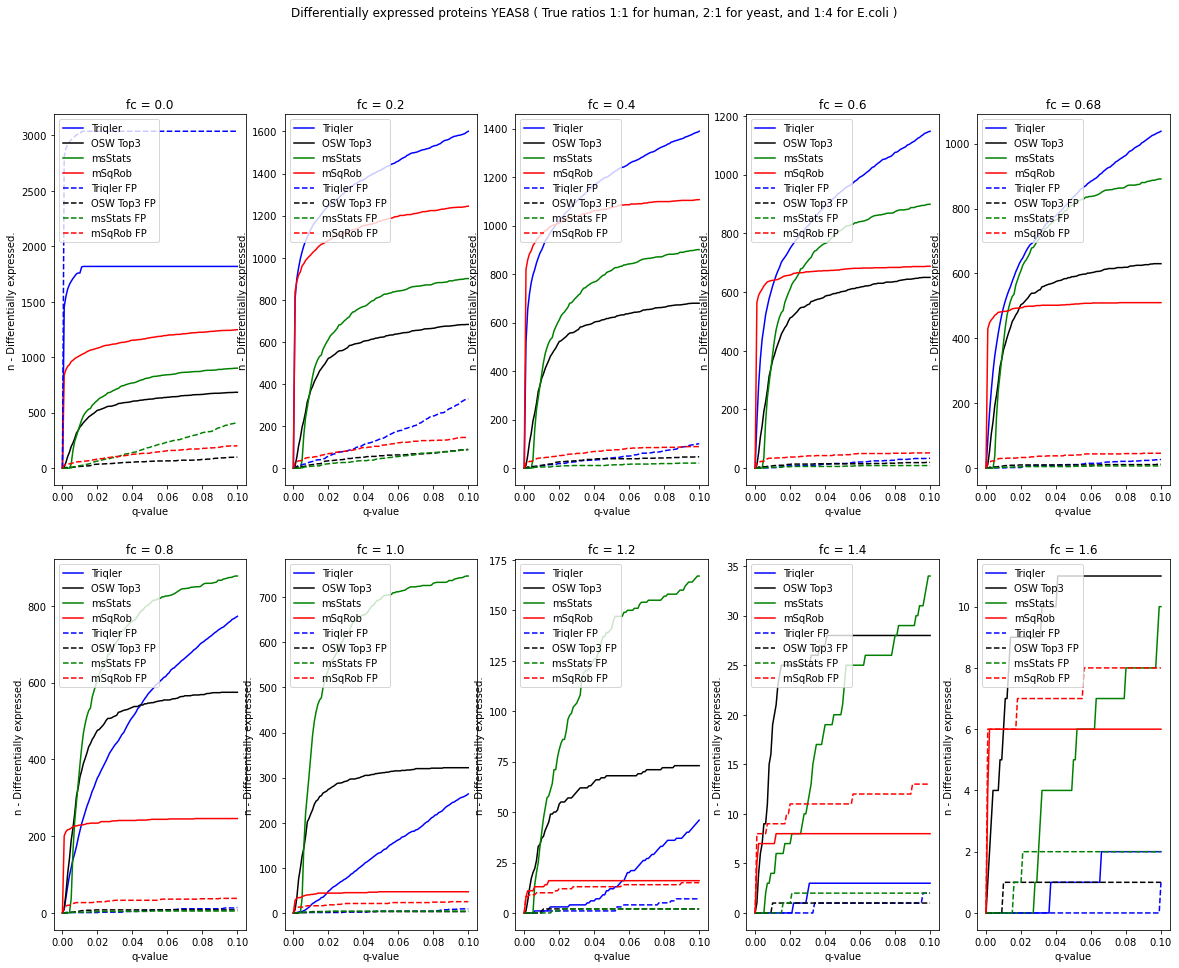

In [23]:
plot_pq_specie_FP(specie = "YEAS8", fcs = fcs)


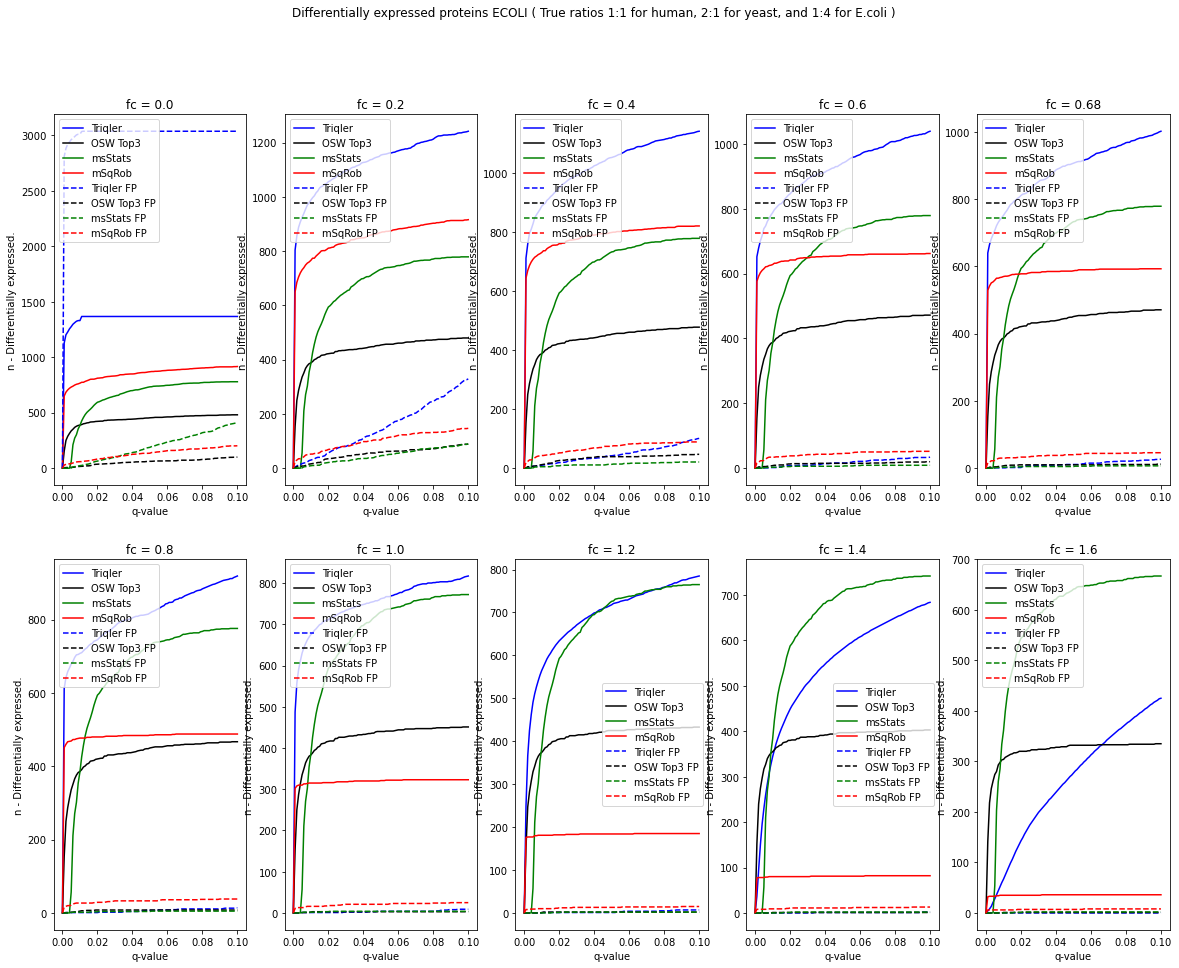

In [22]:
plot_pq_specie_FP(specie = "ECOLI", fcs = fcs)


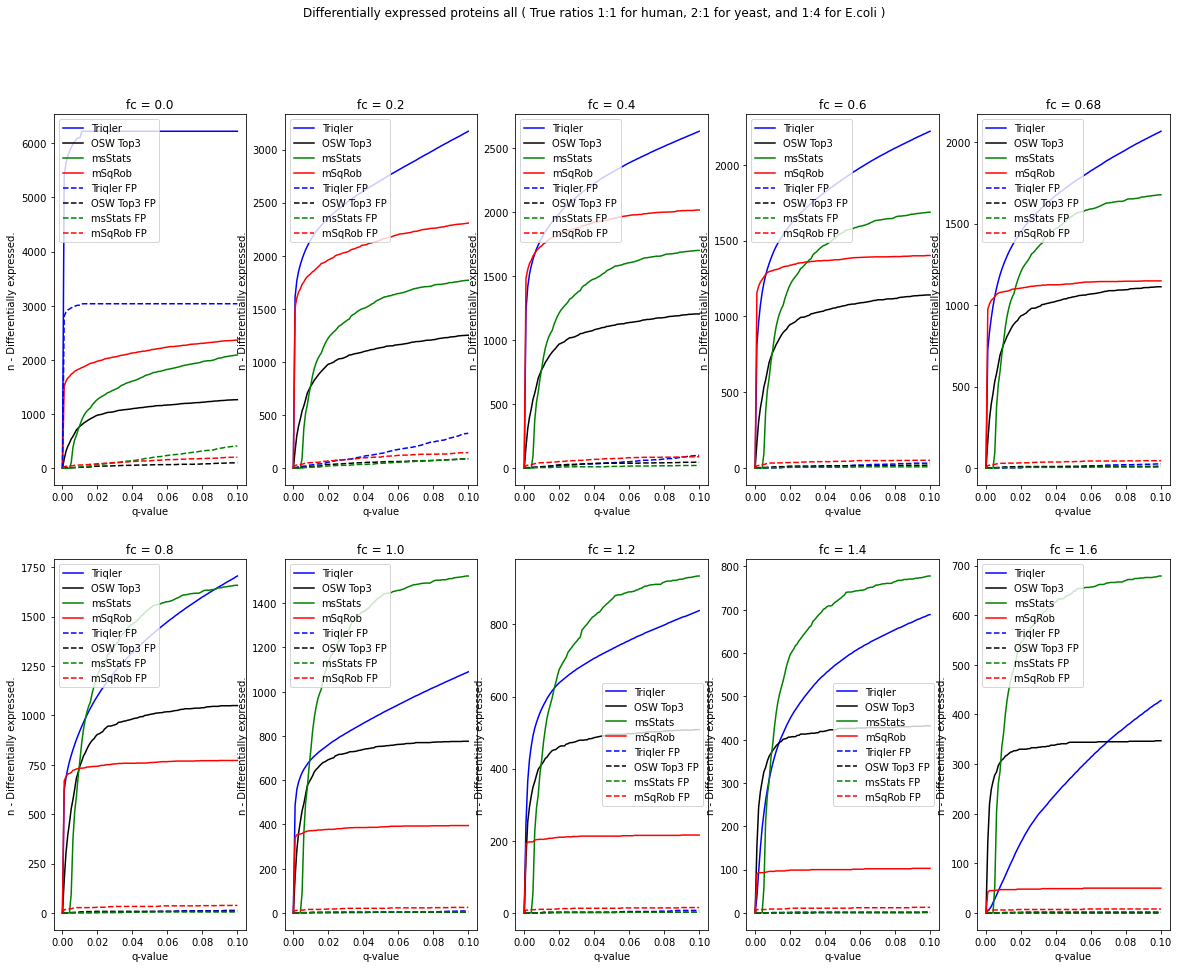

In [21]:
plot_pq_specie_FP(specie = "all", fcs = fcs)

# FP / DE ratio - Calibration plot

### FP is defined as DE-human proteins, DE is for DE for all species.

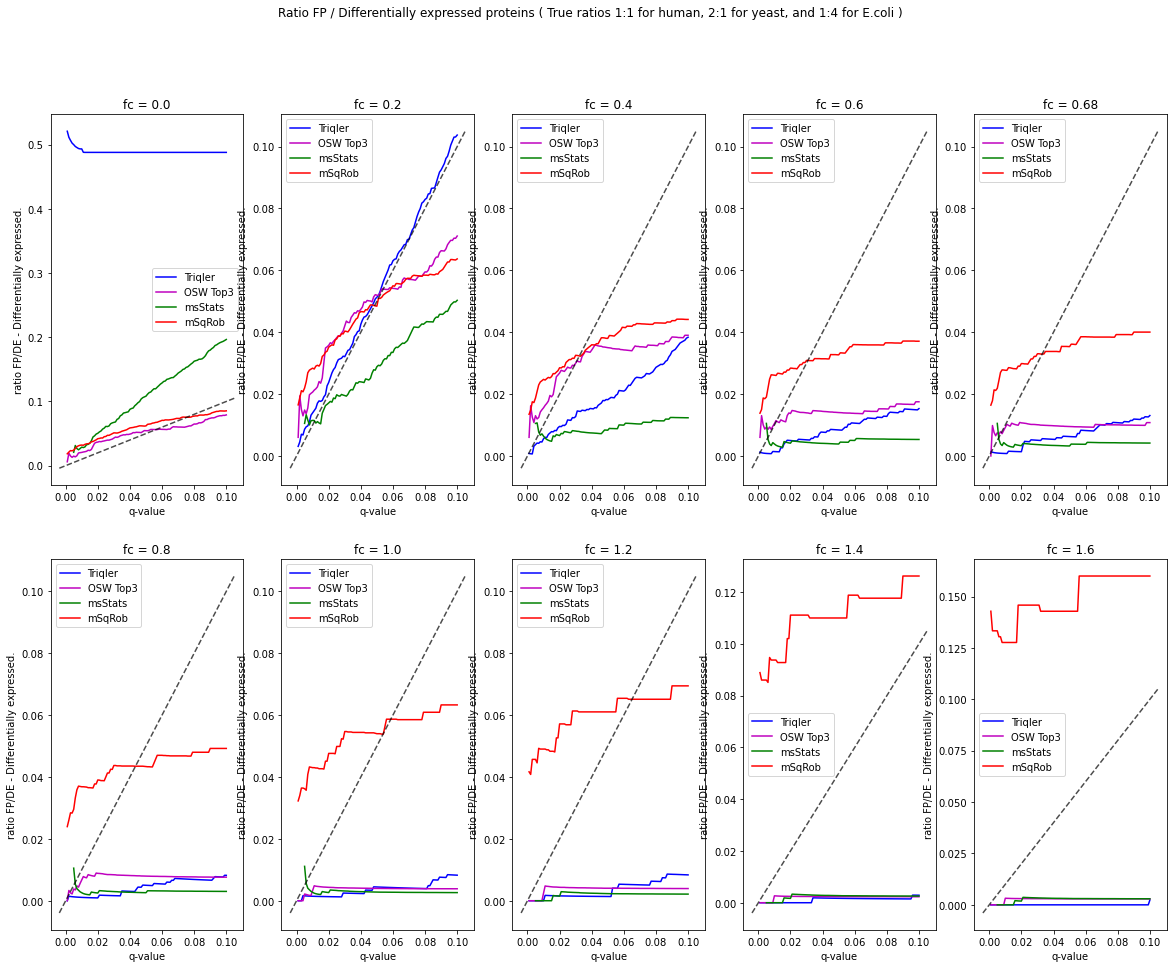

In [36]:
plot_ratio_FP_DE(specie = "all", fcs = fcs)

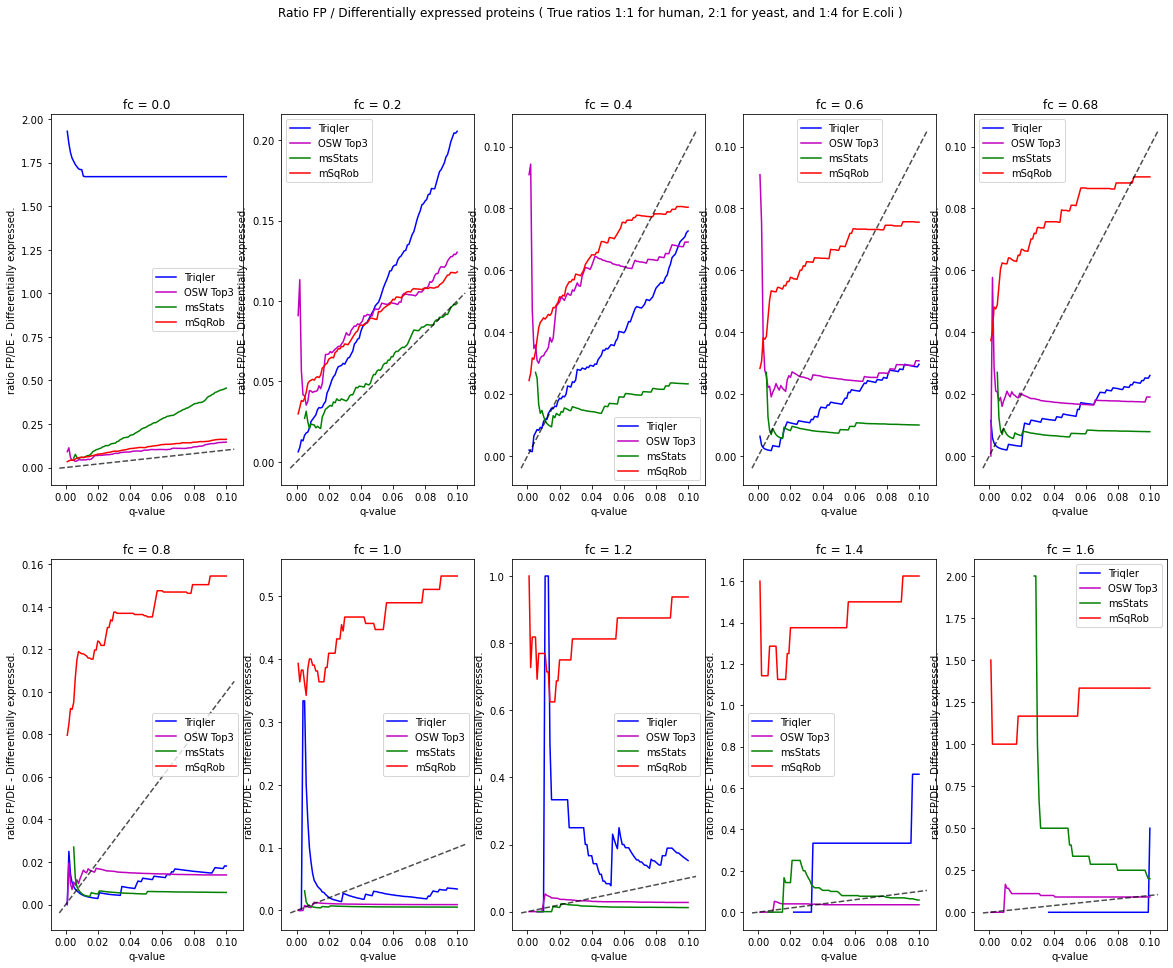

In [38]:
plot_ratio_FP_DE(specie = "YEAS8", fcs = fcs)

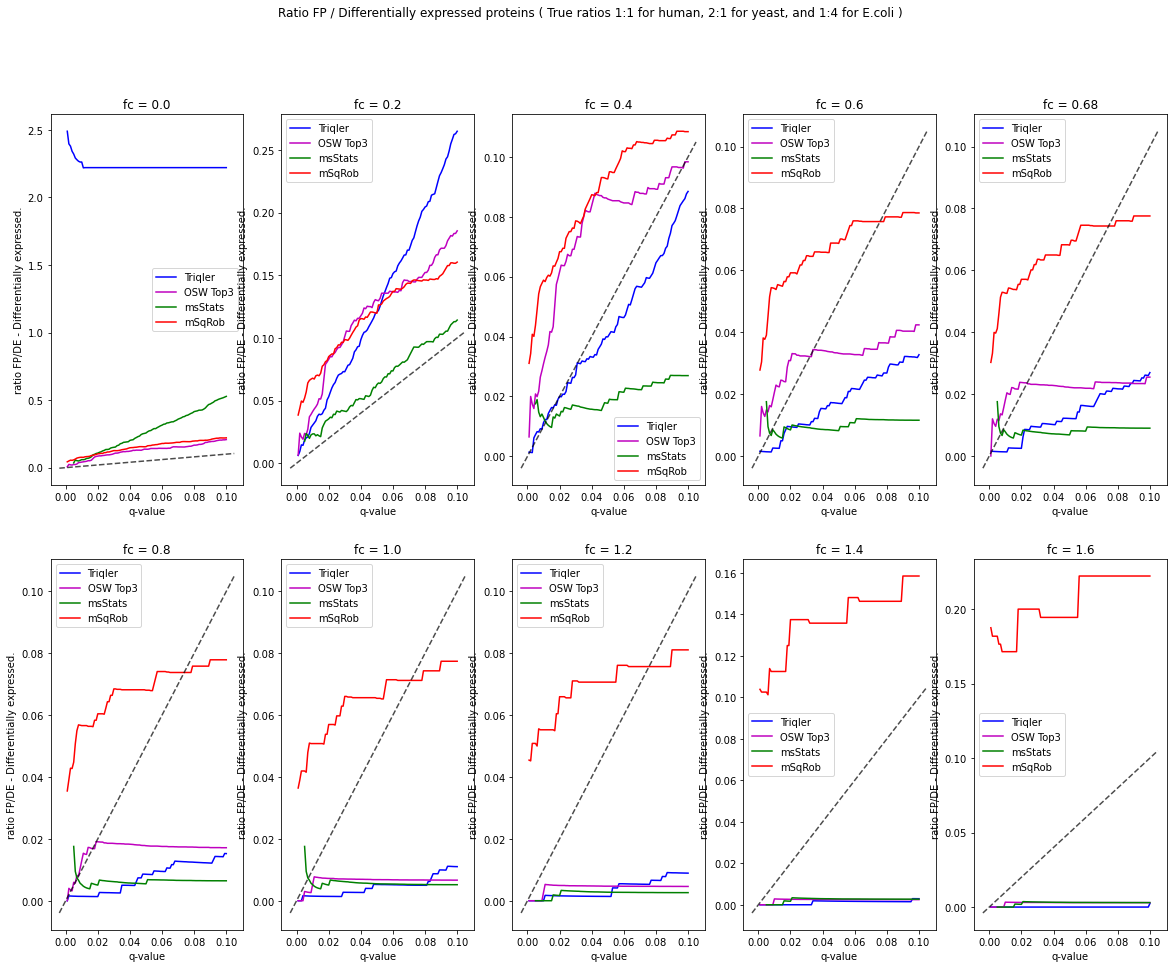

In [39]:
plot_ratio_FP_DE(specie = "ECOLI", fcs = fcs)

# DE YEAST or ECOLI as a function of DE HUMAN

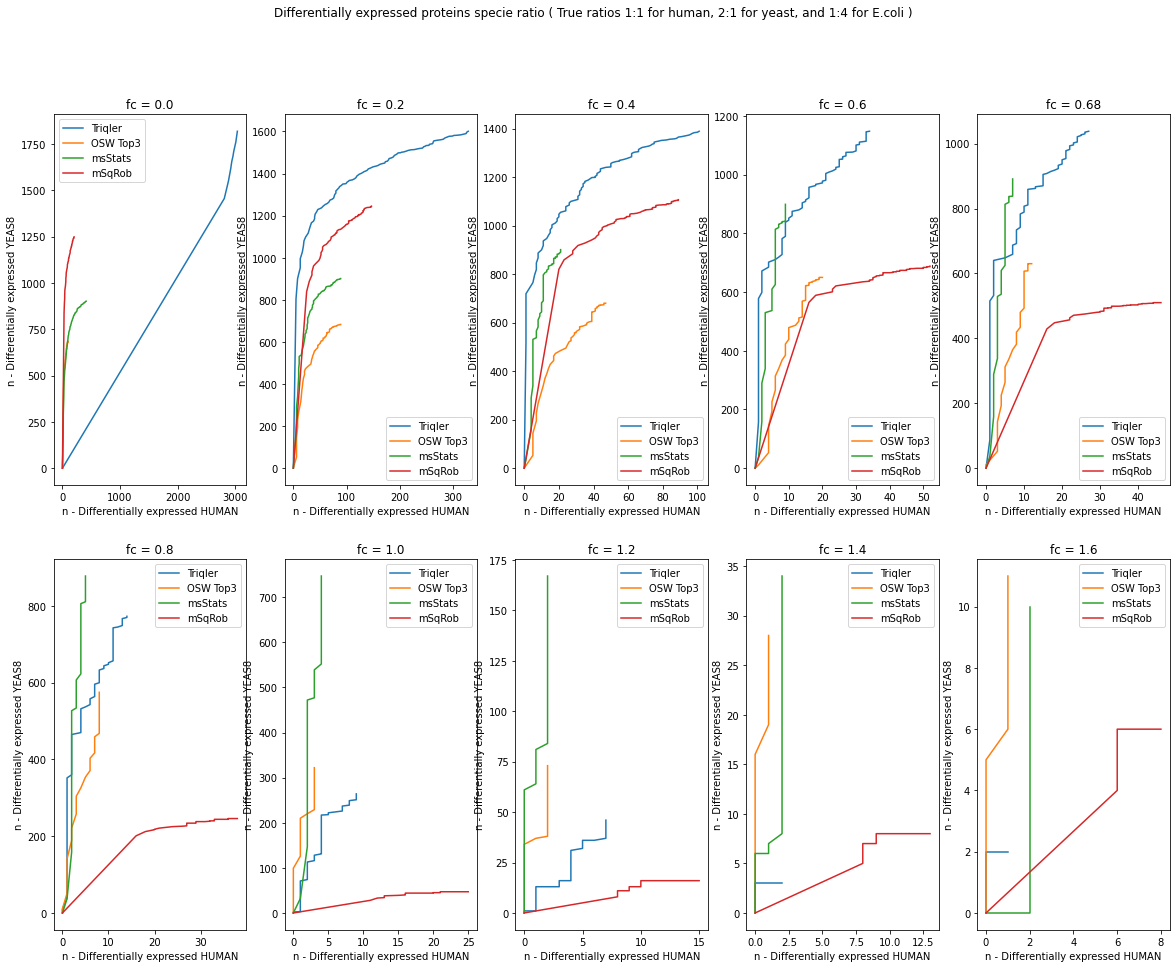

In [26]:
#plot_de_specie_xy(specie_x = "HUMAN")
plot_de_specie_xy(specie_x = "HUMAN",specie_y = "YEAS8", fcs = fcs)


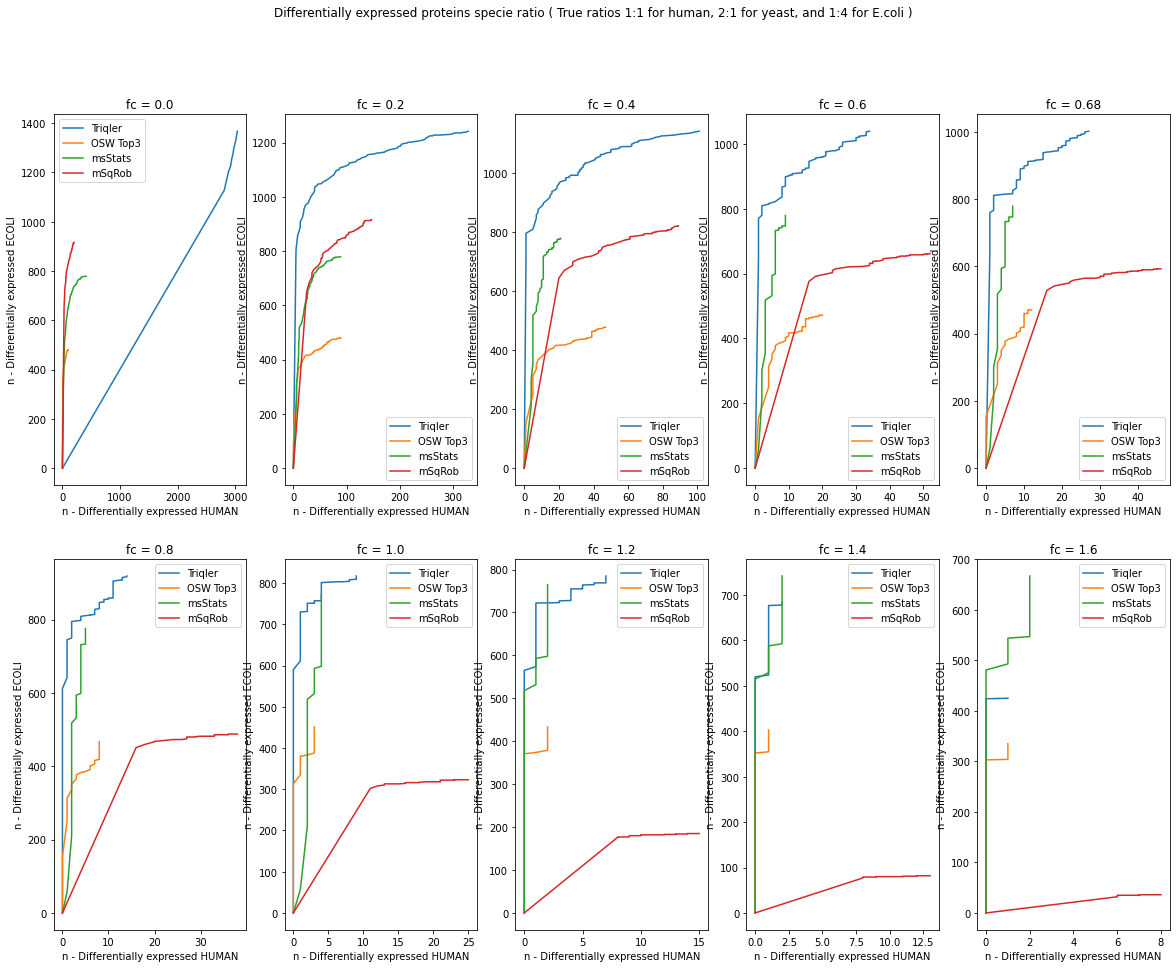

In [27]:
plot_de_specie_xy(specie_x = "HUMAN",specie_y = "ECOLI", fcs = fcs)